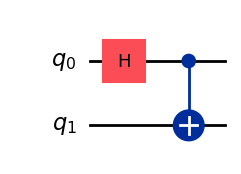

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Create a test circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
qc.draw('mpl')


In [2]:
# Set up six different observables.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

### Choose backend

#### Fake device backend

In [3]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2

backend = FakeAlmadenV2() 
backend.num_qubits

20

#### Real quantum  backend
_If you have not previously saved your credentials, follow instructions at
https://docs.quantum.ibm.com/guides/setup-channel#iqp
to authenticate with your API token._
  
Uncomment the cell below to run on a real device.

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
# service = QiskitRuntimeService()
 
# backend = service.least_busy(operational=True)


In [5]:
# Define Estimator primitive on the specified backend
estimator = Estimator(backend)

#### Compile with Qiskit

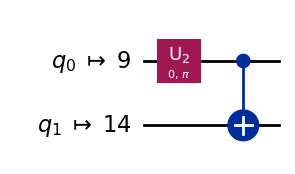

In [6]:
# Convert to an ISA (Instruction Set Architecture) circuit, i.e. map it to the specified backend
qiskit_pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
qiskit_isa_circ = qiskit_pass_manager.run(qc)
 
qiskit_isa_circ.draw("mpl", idle_wires=False)

In [7]:
# Map observables to the same layout as the ISA circuit
qis_mapped_observables = [
    observable.apply_layout(qiskit_isa_circ.layout) for observable in observables
]

In [8]:
#### Run Qiskit-commpiled circuit
qiskit_job = estimator.run([(qiskit_isa_circ, qis_mapped_observables)])

In [9]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
qiskit_result = qiskit_job.result()

# This is the result from our single pub, which had five observables,
# so contains information on all five.
 
qis_pub_result = qiskit_job.result()[0]

#### Vizualize Qiskit-compiled result

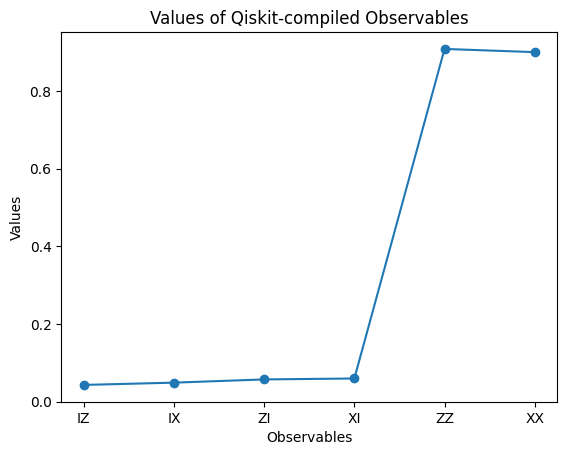

In [10]:
# Plot the result
 
from matplotlib import pyplot as plt
 
qis_values = qis_pub_result.data.evs
 
qis_errors = qis_pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, qis_values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.title("Values of Qiskit-compiled Observables")
plt.show()

### Compile with UCC

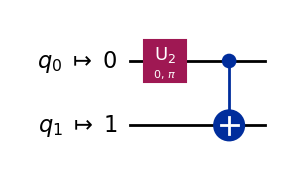

In [11]:
# Convert to an ISA (Instruction Set Architecture) circuit, i.e. map it to the specified backend
import ucc

ucc_isa_circ = ucc.compile(qc, target_device=backend)
 
ucc_isa_circ.draw("mpl", idle_wires=False)

In [12]:
# Map observables to the same layout as the ISA circuit
ucc_mapped_observables = [
    observable.apply_layout(ucc_isa_circ.layout) for observable in observables
]

In [13]:
#### Run UCC-commpiled circuit
ucc_job = estimator.run([(ucc_isa_circ, ucc_mapped_observables)])

In [14]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
ucc_result = ucc_job.result()

# This is the result from our single pub, which had five observables,
# so contains information on all five.
 
ucc_pub_result = ucc_job.result()[0]

#### Vizualize UCC-compiled result

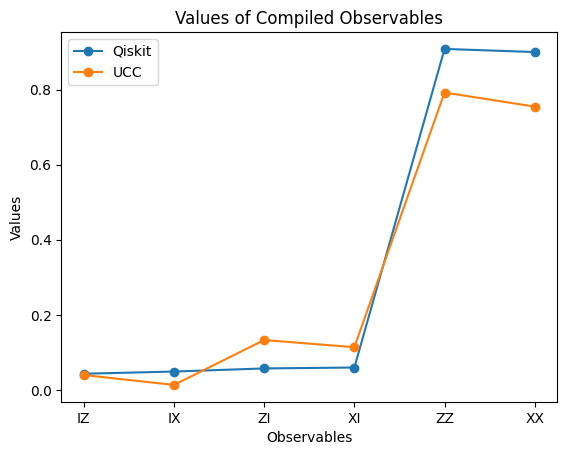

In [15]:
# Plot the result
 
from matplotlib import pyplot as plt
 
ucc_values = ucc_pub_result.data.evs
 
ucc_errors = ucc_pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, qis_values, "-o")
plt.plot(observables_labels, ucc_values, "-o")
plt.legend(["Qiskit", "UCC"])
plt.xlabel("Observables")
plt.ylabel("Values")
plt.title("Values of Compiled Observables")
plt.show()

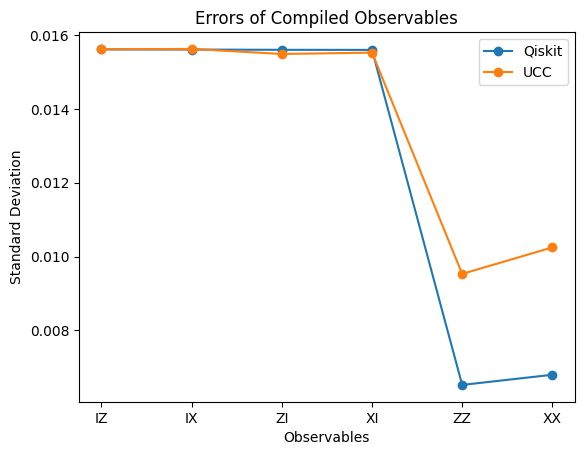

In [16]:
# plotting graph
plt.plot(observables_labels, qis_errors, "-o")
plt.plot(observables_labels, ucc_errors, "-o")
plt.legend(["Qiskit", "UCC"])
plt.xlabel("Observables")
plt.ylabel("Standard Deviation")
plt.title("Errors of Compiled Observables")
plt.show()